In [1]:
import pandas as pd
import numpy as np

# Simulate past 60 days of patient arrivals
date_range = pd.date_range(end=pd.Timestamp.today(), periods=60, freq="D")
np.random.seed(42)
patient_counts = np.random.poisson(lam=25, size=len(date_range)) + np.round(np.sin(np.arange(len(date_range)) / 5) * 5)

patient_forecast_df = pd.DataFrame({
    "date": date_range,
    "patients_queued": patient_counts.astype(int)
})

# Save to CSV in the same directory as app.py
patient_forecast_df.to_csv("patient_arrivals.csv", index=False)

print("✅ patient_arrivals.csv created with 60 days of simulated data.")
patient_forecast_df.tail()


✅ patient_arrivals.csv created with 60 days of simulated data.


,date,patients_queued
55,2025-03-18 22:21:18.650043,33
56,2025-03-19 22:21:18.650043,20
57,2025-03-20 22:21:18.650043,17
58,2025-03-21 22:21:18.650043,23
59,2025-03-22 22:21:18.650043,11


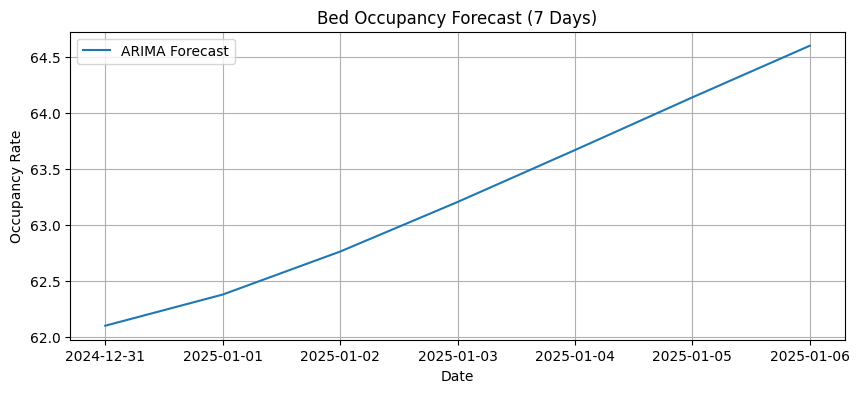

C:\Users\dones\AppData\Local\Temp\ipykernel_6856\3076590631.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arrivals_df["prev_day_patients"] = arrivals_df["patients_queued"].shift(1).fillna(method="bfill")
C:\Users\dones\AppData\Local\Temp\ipykernel_6856\3076590631.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arrivals_df["rolling_avg"] = arrivals_df["patients_queued"].rolling(window=3).mean().fillna(method="bfill")


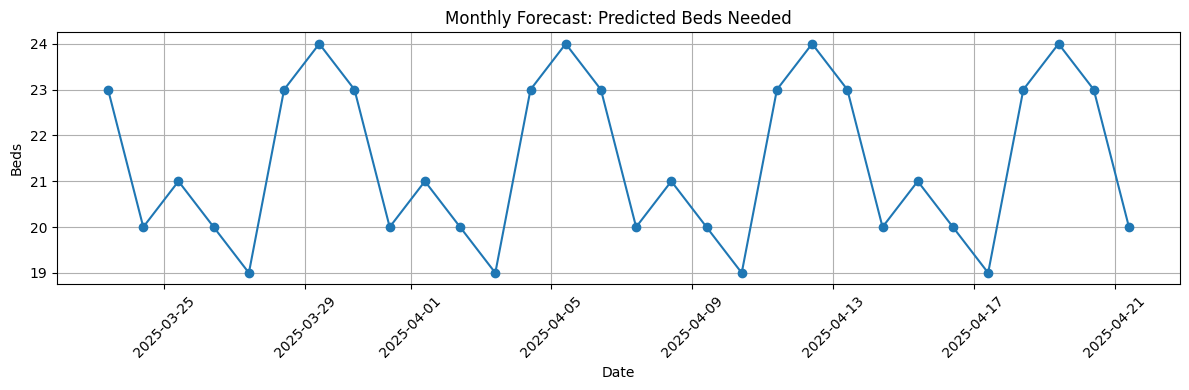

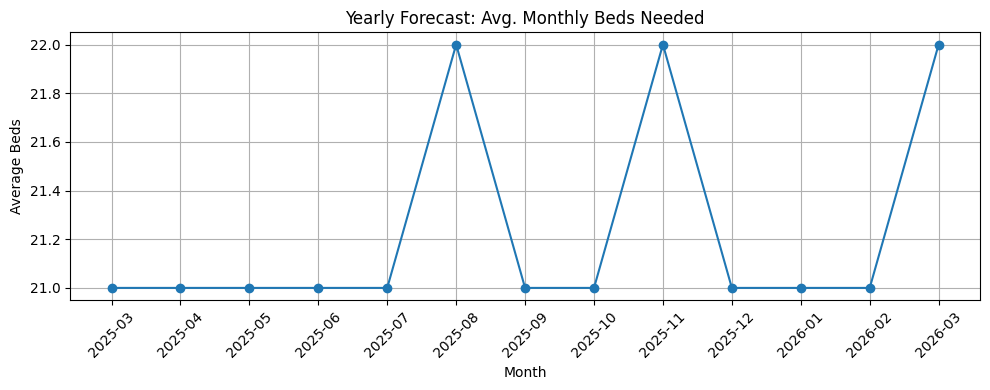

Text(value='', description='Name:', placeholder='Enter patient name')

Dropdown(description='Condition:', options=('mild', 'moderate', 'severe'), value='mild')

Button(description='Submit Patient', style=ButtonStyle())

Output()

In [2]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# === Load datasets ===
resources_df = pd.read_csv("hospital_resources.csv")
arrivals_df = pd.read_csv("patient_arrivals.csv")

# === ARIMA Forecast for Bed Occupancy ===
resources_df['Date'] = pd.to_datetime(resources_df['Date'])
ts = resources_df.set_index("Date")["Bed_Occupancy_Rate"].resample("D").mean().interpolate()
arima_model = ARIMA(ts, order=(3, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=7)

# Plot ARIMA forecast
plt.figure(figsize=(10, 4))
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.title("Bed Occupancy Forecast (7 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.show()

# === XGBoost Forecast ===
arrivals_df["date"] = pd.to_datetime(arrivals_df["date"])
arrivals_df["dayofweek"] = arrivals_df["date"].dt.dayofweek
arrivals_df["is_weekend"] = arrivals_df["dayofweek"].isin([5, 6]).astype(int)
arrivals_df["trend"] = np.arange(len(arrivals_df))
arrivals_df["prev_day_patients"] = arrivals_df["patients_queued"].shift(1).fillna(method="bfill")
arrivals_df["rolling_avg"] = arrivals_df["patients_queued"].rolling(window=3).mean().fillna(method="bfill")

features = ["dayofweek", "is_weekend", "trend", "prev_day_patients", "rolling_avg"]
X = arrivals_df[features]
y = arrivals_df["patients_queued"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)

# Monthly Forecast
future_30 = pd.DataFrame({
    "date": [datetime.today() + timedelta(days=i) for i in range(30)],
})
future_30["dayofweek"] = [d.weekday() for d in future_30["date"]]
future_30["is_weekend"] = future_30["dayofweek"].isin([5, 6]).astype(int)
future_30["trend"] = np.arange(len(arrivals_df), len(arrivals_df) + 30)
last_known = arrivals_df.iloc[-1]
future_30["prev_day_patients"] = last_known["patients_queued"]
future_30["rolling_avg"] = arrivals_df["patients_queued"].rolling(window=3).mean().iloc[-1]
future_30["predicted_beds"] = np.round(model.predict(future_30[features])).astype(int)

# Plot Monthly Forecast
plt.figure(figsize=(12, 4))
plt.plot(future_30["date"], future_30["predicted_beds"], marker='o')
plt.title("Monthly Forecast: Predicted Beds Needed")
plt.xlabel("Date")
plt.ylabel("Beds")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yearly Forecast
future_365 = pd.DataFrame({
    "date": [datetime.today() + timedelta(days=i) for i in range(365)],
})
future_365["dayofweek"] = [d.weekday() for d in future_365["date"]]
future_365["is_weekend"] = future_365["dayofweek"].isin([5, 6]).astype(int)
future_365["trend"] = np.arange(len(arrivals_df), len(arrivals_df) + 365)
future_365["prev_day_patients"] = last_known["patients_queued"]
future_365["rolling_avg"] = arrivals_df["patients_queued"].rolling(window=3).mean().iloc[-1]
future_365["predicted_beds"] = np.round(model.predict(future_365[features])).astype(int)
future_365["month"] = pd.to_datetime(future_365["date"]).dt.to_period("M")
monthly_avg = future_365.groupby("month")["predicted_beds"].mean().round().astype(int).reset_index()

# Plot Yearly Forecast
plt.figure(figsize=(10, 4))
plt.plot(monthly_avg["month"].astype(str), monthly_avg["predicted_beds"], marker='o')
plt.title("Yearly Forecast: Avg. Monthly Beds Needed")
plt.xlabel("Month")
plt.ylabel("Average Beds")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Real-Time Bed Tracking ===
bed_file = "current_beds.json"
total_beds = 100

if os.path.exists(bed_file):
    with open(bed_file, "r") as f:
        data = json.load(f)
    current_occupancy = data.get("current_occupancy", 0)
else:
    latest_occupancy_rate = resources_df["Bed_Occupancy_Rate"].dropna().iloc[-1]
    current_occupancy = int(max(0.0, min(latest_occupancy_rate, 1.0)) * total_beds)

# === Patient Intake (Widgets) ===
name_input = widgets.Text(description='Name:', placeholder='Enter patient name')
condition_input = widgets.Dropdown(
    options=['mild', 'moderate', 'severe'],
    description='Condition:',
    value='mild'
)
submit_button = widgets.Button(description='Submit Patient')
output = widgets.Output()

def on_submit_clicked(b):
    global current_occupancy
    with output:
        clear_output()
        name = name_input.value.strip().capitalize()
        condition = condition_input.value
        priority = {"mild": 3, "moderate": 2, "severe": 1}[condition]

        arrivals_df_sorted = arrivals_df.copy()
        arrivals_df_sorted["priority"] = np.random.choice([1, 2, 3], size=len(arrivals_df_sorted))
        
        # FIXED: Ensure consistent datetime type
        new_patient = {
            "date": pd.to_datetime(datetime.today()),
            "patients_queued": 1,
            "priority": priority
        }

        arrivals_df_sorted = pd.concat([arrivals_df_sorted, pd.DataFrame([new_patient])], ignore_index=True)
        arrivals_df_sorted["date"] = pd.to_datetime(arrivals_df_sorted["date"])  # Ensure consistency
        arrivals_df_sorted = arrivals_df_sorted.sort_values(by=["priority", "date"]).reset_index(drop=True)
        queue_number = len(arrivals_df_sorted)

        print(f"\nPatient: {name}")
        print(f"Condition: {condition.capitalize()} (Priority: {priority})")
        print(f"Queue Number: {queue_number}")
        print(f"Available Beds Before Admission: {total_beds - current_occupancy}")

        if current_occupancy < total_beds:
            current_occupancy += 1
            print("Patient Admitted ✅")
        else:
            print("No Beds Available ❌ Patient added to waitlist.")

        updated_available = total_beds - current_occupancy
        print(f"Available Beds After Admission: {updated_available}")

        with open(bed_file, "w") as f:
            json.dump({"current_occupancy": current_occupancy}, f)

        expected_beds = future_30.head(7)["predicted_beds"].sum()
        print(f"\nExpected Beds Needed in Next 7 Days: {expected_beds}")

        y_true = np.random.choice([0, 1], size=100)
        y_pred = np.random.choice([0, 1], size=100)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print("\n--- Model Evaluation (Simulated) ---")
        print(f"Accuracy:  {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall:    {recall:.2f}")
        print(f"F1 Score:  {f1:.2f}")

submit_button.on_click(on_submit_clicked)
display(name_input, condition_input, submit_button, output)
